使用评论文本将影评分为积极（positive）或消极（nagetive）两类。

这是一个二元（binary）或者二分类问题，一种重要且应用广泛的机器学习问题

将使用来源于网络电影数据库（Internet Movie Database）的 IMDB 数据集（IMDB dataset），其包含 50,000 条影评文本。从该数据集切割出的25,000条评论用作训练，另外 25,000 条用作测试。训练集与测试集是平衡的（balanced），意味着它们包含相等数量的积极和消极评论。

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np

print(tf.__version__)

#下载 IMDB 数据集
imdb = keras.datasets.imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

2.6.0
17473536/17464789 [==============================] - 0s 0us/step


In [2]:
#探索数据
print("Training entries: {}, labels: {}".format(len(train_data), len(train_labels)))

Training entries: 25000, labels: 25000


In [3]:
#评论文本被转换为整数值，其中每个整数代表词典中的一个单词。首条评论是这样的
train_data[0]

[1,
 14,
 22,
 16,
 43,
 530,
 973,
 1622,
 1385,
 65,
 458,
 4468,
 66,
 3941,
 4,
 173,
 36,
 256,
 5,
 25,
 100,
 43,
 838,
 112,
 50,
 670,
 2,
 9,
 35,
 480,
 284,
 5,
 150,
 4,
 172,
 112,
 167,
 2,
 336,
 385,
 39,
 4,
 172,
 4536,
 1111,
 17,
 546,
 38,
 13,
 447,
 4,
 192,
 50,
 16,
 6,
 147,
 2025,
 19,
 14,
 22,
 4,
 1920,
 4613,
 469,
 4,
 22,
 71,
 87,
 12,
 16,
 43,
 530,
 38,
 76,
 15,
 13,
 1247,
 4,
 22,
 17,
 515,
 17,
 12,
 16,
 626,
 18,
 2,
 5,
 62,
 386,
 12,
 8,
 316,
 8,
 106,
 5,
 4,
 2223,
 5244,
 16,
 480,
 66,
 3785,
 33,
 4,
 130,
 12,
 16,
 38,
 619,
 5,
 25,
 124,
 51,
 36,
 135,
 48,
 25,
 1415,
 33,
 6,
 22,
 12,
 215,
 28,
 77,
 52,
 5,
 14,
 407,
 16,
 82,
 2,
 8,
 4,
 107,
 117,
 5952,
 15,
 256,
 4,
 2,
 7,
 3766,
 5,
 723,
 36,
 71,
 43,
 530,
 476,
 26,
 400,
 317,
 46,
 7,
 4,
 2,
 1029,
 13,
 104,
 88,
 4,
 381,
 15,
 297,
 98,
 32,
 2071,
 56,
 26,
 141,
 6,
 194,
 7486,
 18,
 4,
 226,
 22,
 21,
 134,
 476,
 26,
 480,
 5,
 144,
 30,
 5535,
 18,

In [4]:
#电影评论可能具有不同的长度。以下代码显示了第一条和第二条评论的中单词数量。
#由于神经网络的输入必须是统一的长度，我们稍后需要解决这个问题。
len(train_data[0]), len(train_data[1])

(218, 189)

In [5]:
#将整数转换回单词
#了解如何将整数转换回文本对您可能是有帮助的。这里我们将创建一个辅助函数来查询一个包含了整数到字符串映射的字典对象：

# 一个映射单词到整数索引的词典
word_index = imdb.get_word_index()

# 保留第一个索引
word_index = {k:(v+3) for k,v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

1654784/1641221 [==============================] - 0s 0us/step


In [6]:
#使用 decode_review 函数来显示首条评论的文本
decode_review(train_data[0])

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

In [7]:
#准备数据
#创建一个大小为 max_length * num_reviews 的整型张量。我们可以使用能够处理此形状数据的嵌入层作为网络中的第一层
train_data = keras.preprocessing.sequence.pad_sequences(train_data,
                            value=word_index["<PAD>"],
                            padding='post',
                            maxlen=256)

test_data = keras.preprocessing.sequence.pad_sequences(test_data,
                            value=word_index["<PAD>"],
                            padding='post',
                            maxlen=256)

#现在让我们看下样本的长度
len(train_data[0]), len(train_data[1])

(256, 256)

In [8]:
#并检查一下首条评论（当前已经填充）
train_data[0]

array([   1,   14,   22,   16,   43,  530,  973, 1622, 1385,   65,  458,
       4468,   66, 3941,    4,  173,   36,  256,    5,   25,  100,   43,
        838,  112,   50,  670,    2,    9,   35,  480,  284,    5,  150,
          4,  172,  112,  167,    2,  336,  385,   39,    4,  172, 4536,
       1111,   17,  546,   38,   13,  447,    4,  192,   50,   16,    6,
        147, 2025,   19,   14,   22,    4, 1920, 4613,  469,    4,   22,
         71,   87,   12,   16,   43,  530,   38,   76,   15,   13, 1247,
          4,   22,   17,  515,   17,   12,   16,  626,   18,    2,    5,
         62,  386,   12,    8,  316,    8,  106,    5,    4, 2223, 5244,
         16,  480,   66, 3785,   33,    4,  130,   12,   16,   38,  619,
          5,   25,  124,   51,   36,  135,   48,   25, 1415,   33,    6,
         22,   12,  215,   28,   77,   52,    5,   14,  407,   16,   82,
          2,    8,    4,  107,  117, 5952,   15,  256,    4,    2,    7,
       3766,    5,  723,   36,   71,   43,  530,  4

In [9]:
#构建模型
vocab_size = 10000

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 16))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


In [11]:
#损失函数与优化器
model.compile(optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy'])

#创建一个验证集
x_val = train_data[:10000]
partial_x_train = train_data[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

#训练模型
#以 512 个样本的 mini-batch 大小迭代 40 个 epoch 来训练模型。这是指对 x_train 和 y_train 张量中所有样本的的 40 次迭代。
#在训练过程中，监测来自验证集的 10,000 个样本上的损失值（loss）和准确率（accuracy）
history = model.fit(partial_x_train,
          partial_y_train,
          epochs=40,
          batch_size=512,
          validation_data=(x_val, y_val),
          verbose=1)

Epoch 1/40
30/30 [==============================] - 2s 22ms/step - loss: 0.6923 - accuracy: 0.6084 - val_loss: 0.6909 - val_accuracy: 0.7161
Epoch 2/40
30/30 [==============================] - 1s 17ms/step - loss: 0.6884 - accuracy: 0.7123 - val_loss: 0.6854 - val_accuracy: 0.7450
Epoch 3/40
30/30 [==============================] - 1s 17ms/step - loss: 0.6796 - accuracy: 0.7293 - val_loss: 0.6734 - val_accuracy: 0.7552
Epoch 4/40
30/30 [==============================] - 0s 16ms/step - loss: 0.6623 - accuracy: 0.7431 - val_loss: 0.6531 - val_accuracy: 0.7666
Epoch 5/40
30/30 [==============================] - 1s 18ms/step - loss: 0.6351 - accuracy: 0.7786 - val_loss: 0.6232 - val_accuracy: 0.7653
Epoch 6/40
30/30 [==============================] - 1s 18ms/step - loss: 0.5983 - accuracy: 0.7991 - val_loss: 0.5860 - val_accuracy: 0.7997
Epoch 7/40
30/30 [==============================] - 1s 17ms/step - loss: 0.5548 - accuracy: 0.8189 - val_loss: 0.5438 - val_accuracy: 0.8134
Epoch 8/40
30

In [12]:
#评估模型
#我们来看一下模型的性能如何。将返回两个值。损失值（loss）（一个表示误差的数字，值越低越好）与准确率（accuracy）
results = model.evaluate(test_data,  test_labels, verbose=2)
print(results)

782/782 - 1s - loss: 0.3247 - accuracy: 0.8728
[0.32465922832489014, 0.872759997844696]


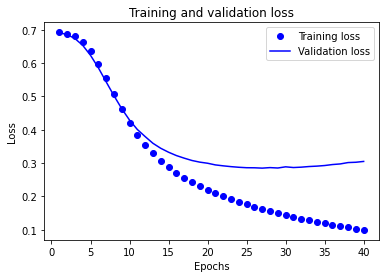

In [13]:
#创建一个准确率（accuracy）和损失值（loss）随时间变化的图表
history_dict = history.history
history_dict.keys()

import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# “bo”代表 "蓝点"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b代表“蓝色实线”
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

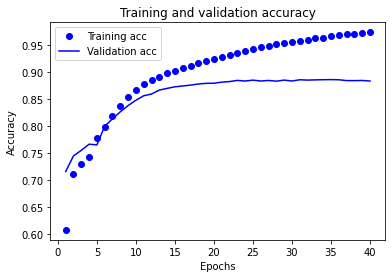

In [14]:
plt.clf()   # 清除数字

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()